In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
from glob import glob
import pathlib
from IPython import display
import PIL
from PIL import Image, ImageDraw
import copy

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import six
import math
import lmdb
import keras_ocr

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 1. 직접 만들어보는 OCR

## (1) Dataset for OCR

In [2]:
path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## (2) Recognition model

In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 1) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


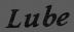

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


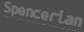

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


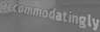

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


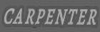

In [5]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
    
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [6]:
class MJDatasetSequence(Sequence):
    
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)

    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    

    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### 2) Encode

In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 3) Build CRNN model

In [9]:
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 4) Train & Inference

In [11]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [12]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min')
model.fit(train_set, steps_per_epoch=len(train_set), epochs=20, validation_data=val_set, 
          validation_steps=len(val_set), callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - 100s 154ms/step - loss: 25.5276 - val_loss: 23.5181

Epoch 00001: val_loss improved from inf to 23.51808, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 86s 152ms/step - loss: 14.8191 - val_loss: 9.9564

Epoch 00002: val_loss improved from 23.51808 to 9.95636, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 86s 151ms/step - loss: 7.1887 - val_loss: 6.4169

Epoch 00003: val_loss improved from 9.95636 to 6.41693, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 85s 151ms/step - loss: 5.1765 - val_loss: 5.4043

Epoch 00004: val_loss improved from 6.41693 to 5.40433, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 85s 150ms/step - loss: 4.1212 - val_loss: 4.9114

Epoch 00005: val_loss impr

In [13]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


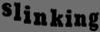

Result: 	 ALEPPO99999999999999999


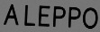

Result: 	 RWENDE999999999999999999


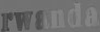

Result: 	 NATHANS99999999999999999


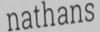

Result: 	 HALLAO99999999999999999


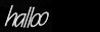

Result: 	 HURLS9999999999999999999


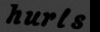

Result: 	 DOWNSIZE9999999999999999


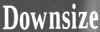

Result: 	 ROBOTIC99999999999999999


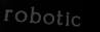

Result: 	 SLAPPY99999999999999999


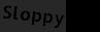

Result: 	 HERMITE99999999999999999


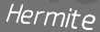

In [14]:
from IPython.display import display

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results


def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# 2. Project_End_to_End_OCR

## (1) keras-ocr Detector

In [15]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [16]:
def detect_text(img_path):
    img_pil = Image.open(img_path)
    img_draw = ImageDraw.Draw(img_pil)
    ocr_result = detector.detect([img_path])
    ocr_result = np.squeeze(np.array(ocr_result))
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))
        
    return img_pil, cropped_imgs

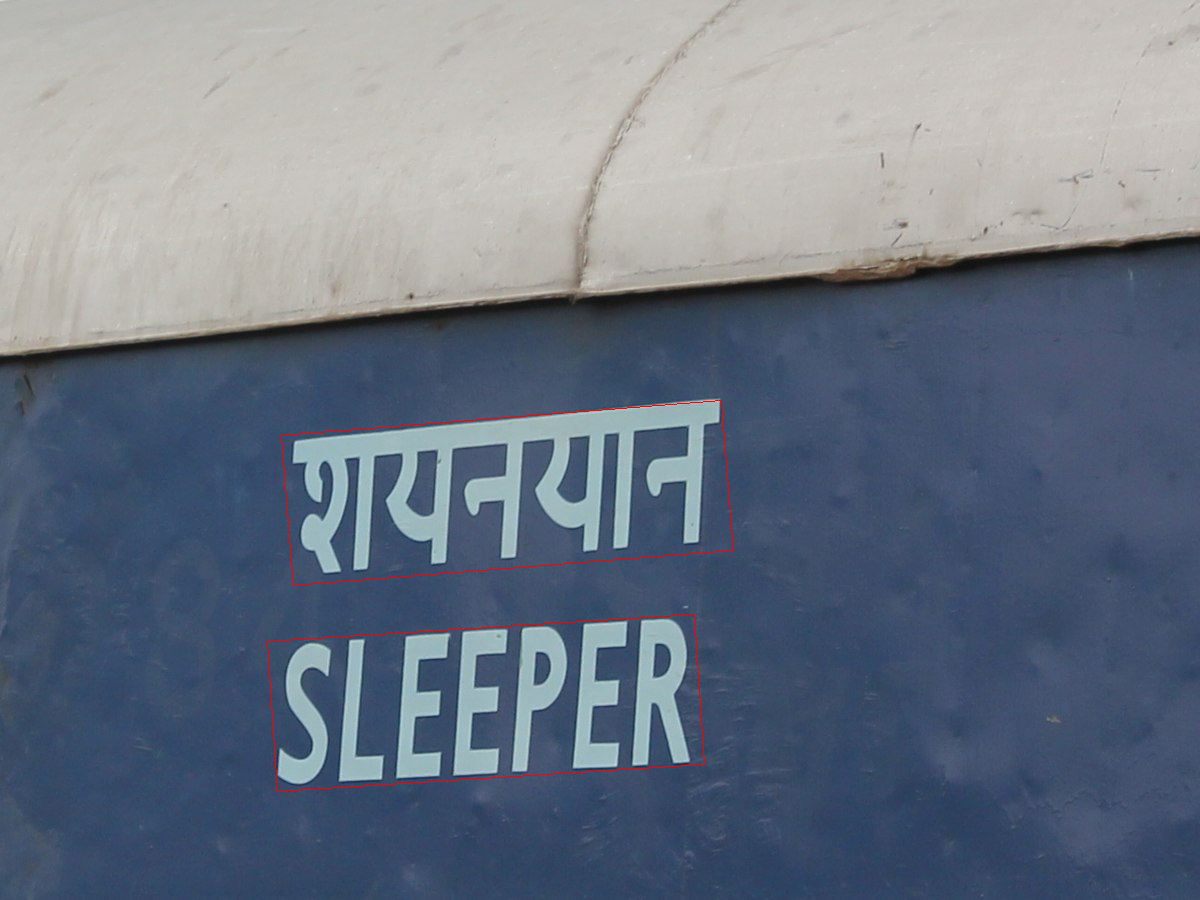

In [17]:
from IPython.display import display

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

## (2) CRNN Recognizer

In [18]:
def recognize_img(pil_img, input_img_size=(100,32)):
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100,32),3)).transpose(1,0,2), axis=0))
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))

Result: 	 RUFRUFI9999999999999999


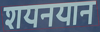

Result: 	 SLEEPER9999999999999999


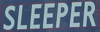

In [19]:
for _img in cropped_img:
    recognize_img(_img)

## (3) End-to-End OCR

### [1]

In [20]:
SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/CV/sample1.jpeg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


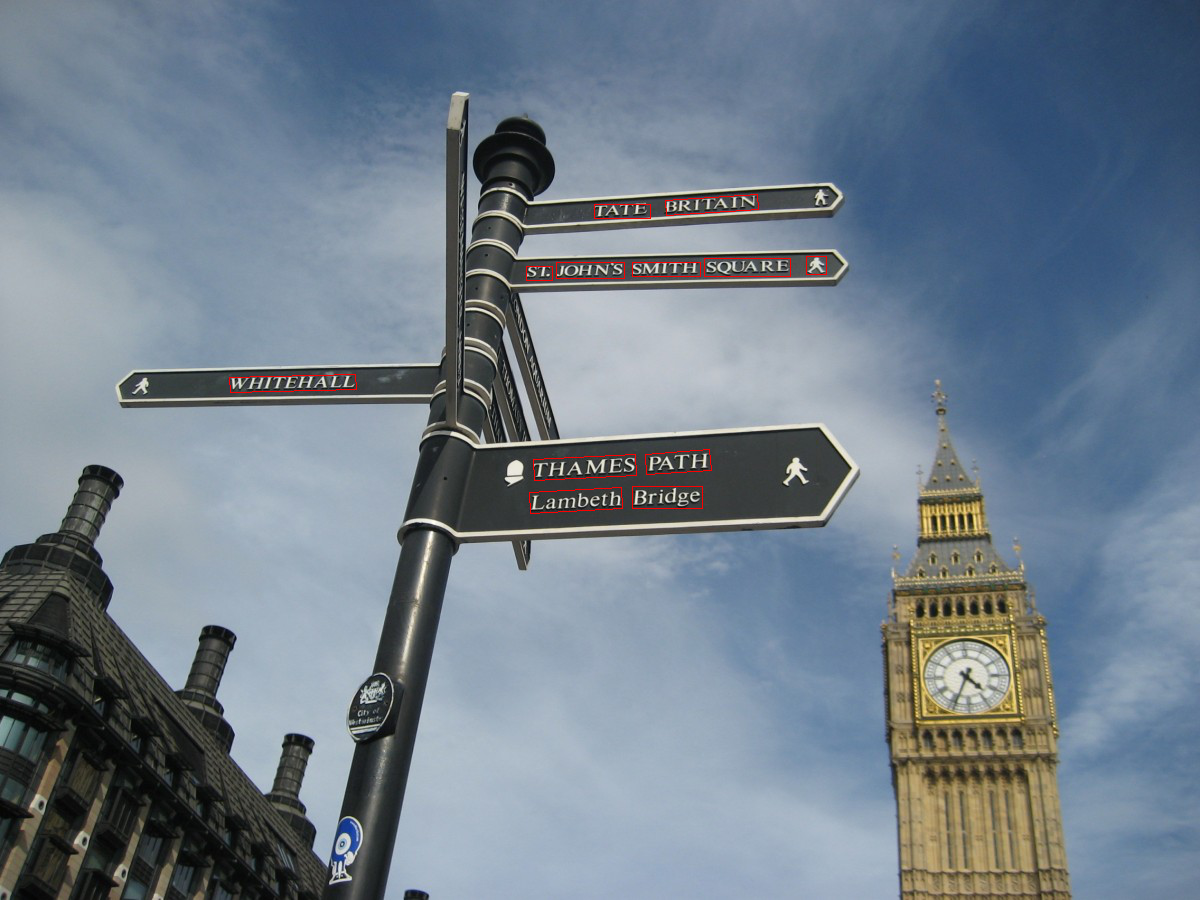

In [21]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 ECATS9999999999999999999


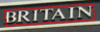

Result: 	 BAUEST999999999999999999


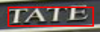

Result: 	 OS9999999999999999999999


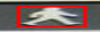

Result: 	 SOUAKIES9999999999999999


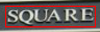

Result: 	 BOHANSE99999999999999999


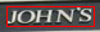

Result: 	 SMVTEL999999999999999999


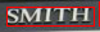

Result: 	 ZSASND99999999999999999


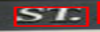

Result: 	 WHNTEBALLE999999999999


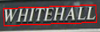

Result: 	 EATHY9999999999999999999


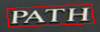

Result: 	 THAMES999999999999999999


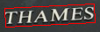

Result: 	 ERIDGE999999999999999999


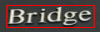

Result: 	 ILAMBETH9999999999999999


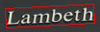

In [22]:
for _img in cropped_img:
    recognize_img(_img)

### [2]

In [23]:
SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/CV/sample2.jpg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


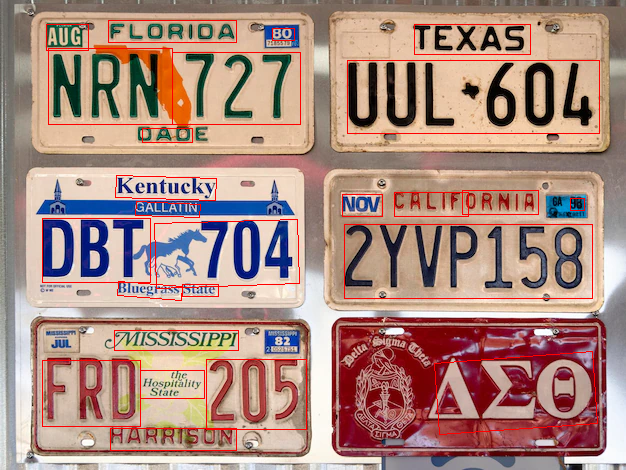

In [24]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 ECORSG999999999999999999


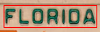

Result: 	 ATUIGE999999999999999999


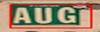

Result: 	 TEXAS9999999999999999999


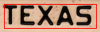

Result: 	 EUEMIPS99999999999999999


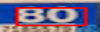

Result: 	 INIRINGEG999999999999999


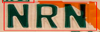

Result: 	 BATZTY999999999999999999


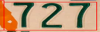

Result: 	 ULBOL9999999999999999999


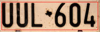

Result: 	 WLSISG99999999999999999


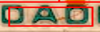

Result: 	 AXENTUCKY999999999999999


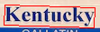

Result: 	 COATNG999999999999999999


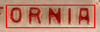

Result: 	 CMSNKE999999999999999999


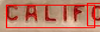

Result: 	 XAGY99999999999999999999


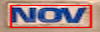

Result: 	 SAMUZD999999999999999999


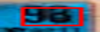

Result: 	 EXIESISG9999999999999999


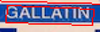

Result: 	 AYETY9999999999999999999


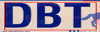

Result: 	 ASZGA999999999999999999


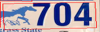

Result: 	 ZYPIS9999999999999999999


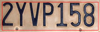

Result: 	 CKDESST999999999999999


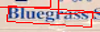

Result: 	 MEUGUT99999999999999999


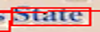

Result: 	 GNISSISSIY999999999999


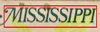

Result: 	 CYTESY999999999999999999


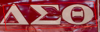

Result: 	 HES999999999999999999999


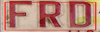

Result: 	 SOFSES999999999999999999


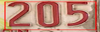

Result: 	 ESNES9999999999999999999


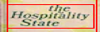

Result: 	 HUENSCE99999999999999999


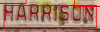

In [25]:
for _img in cropped_img:
    recognize_img(_img)

### [3]

In [26]:
SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/CV/sample3.jpeg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


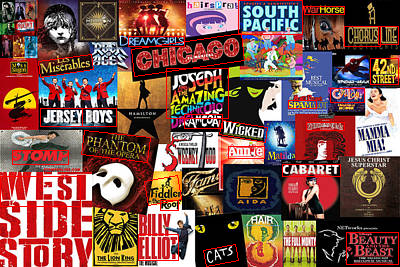

In [27]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 LSSET999999999999999999


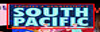

Result: 	 UONSSSEY9999999999999


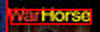

Result: 	 ESEDISH99999999999999999


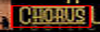

Result: 	 TEAIDCY99999999999999999


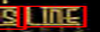

Result: 	 XEXKDS99999999999999999


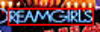

Result: 	 WECNCS999999999999999999


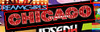

Result: 	 LDOSHEING99999999999999


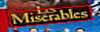

Result: 	 BSISNEY99999999999999999


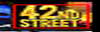

Result: 	 DIESIST99999999999999999


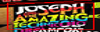

Result: 	 OHMSES999999999999999999


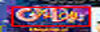

Result: 	 BUSOA9999999999999999999


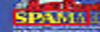

Result: 	 COESEX999999999999999999


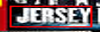

Result: 	 RAEORSY99999999999999999


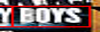

Result: 	 LECOBR999999999999999999


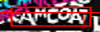

Result: 	 SHLAKENE999999999999999


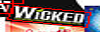

Result: 	 COTE99999999999999999999


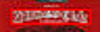

Result: 	 VESESISD99999999999999


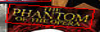

Result: 	 SETILEG99999999999999999


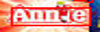

Result: 	 UELNUS999999999999999999


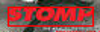

Result: 	 COEOLEY9999999999999999


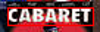

Result: 	 OGUICEL99999999999999999


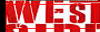

Result: 	 COPRABIDISS999999999999


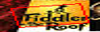

Result: 	 MUEIN9999999999999999999


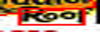

Result: 	 BONELY999999999999999999


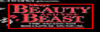

Result: 	 SELIUR999999999999999999


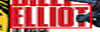

Result: 	 AXCESLY9999999999999999


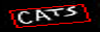

In [28]:
for _img in cropped_img:
    recognize_img(_img)

### [4] 

In [29]:
SAMPLE_IMG_PATH = os.getenv('HOME')+'/aiffel/CV/sample4.jpg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


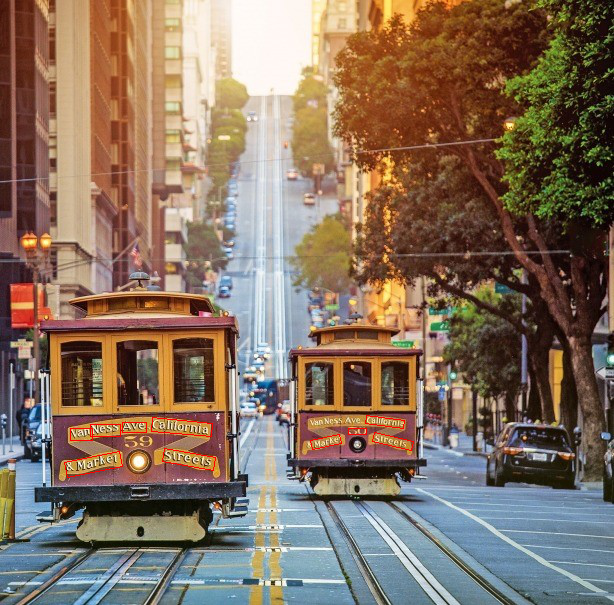

In [30]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 CESNSNG9999999999999999


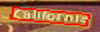

Result: 	 RSEIOCNY9999999999999999


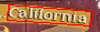

Result: 	 CASI9999999999999999999


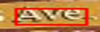

Result: 	 NSSISSIG9999999999999


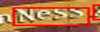

Result: 	 EISSENS999999999999999


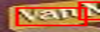

Result: 	 CBTES9999999999999999999


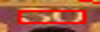

Result: 	 MESESSESS99999999999


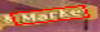

Result: 	 ESTSSEISEY99999999999


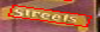

Result: 	 STESESN999999999999999


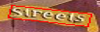

Result: 	 CSENEESSE999999999999


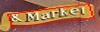

In [31]:
for _img in cropped_img:
    recognize_img(_img)

# 3. References

[1] https://lms.aiffel.io/course/405/node/480

[2] https://arxiv.org/pdf/1507.05717.pdf